In [0]:
import numpy as np
import math
from google.colab import files
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from skimage import color
from skimage import io
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Open the image 
img = Image.open('/content/drive/My Drive/Colab Notebooks/NLA/porosity.jpg')
print(np.asarray(img).shape)

(5405, 4896, 3)


In [4]:
imggray = img.convert('LA')
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)[1000:1576, 1000:1576]
imgmat.shape

(576, 576)

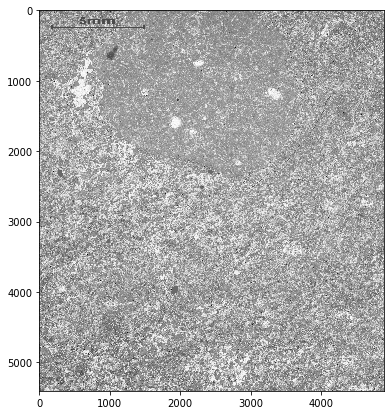

In [5]:
#original image in grayscale
plt.figure(figsize=(7, 7))
plt.imshow(imggray)

In [7]:
type(imggray)

PIL.Image.Image

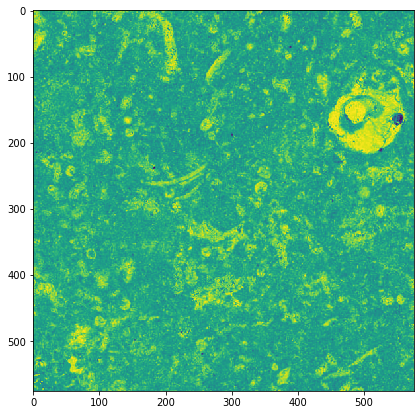

In [0]:
#cropped image
plt.figure(figsize=(7, 7))
plt.imshow(imgmat)

# Part 1. SVD, SSVD

### Define all the functions for SVD part:

In [0]:
from math import sqrt

def compute_sigma(evalues, m, n):
    """
    Compute sigma(middle) matrix of SVD

    :param evalues:
    :param m:
    :param n:
    :return:
    """
    sigma = np.zeros((m, n))

    for i in range(m):
        try:
            sigma[i, i] = evalues[i] ** 0.5
        except IndexError as e:
            continue

    return sigma


def compute_V(evalues, evectors):
    """
    Compute V(right side matrix) of SVD

    :param evalues:
    :param evectors:
    :return:
    """
    evectors = evectors.T

    evalues, evectors = zip(*sorted(zip(evalues, evectors), reverse=True))
    evectors = np.array(evectors)

    V = evectors.T

    return V


def compute_U(matrix, S, V, n):
    """
    Compute U(left side matrix) of SVD

    :param matrix:
    :param S:
    :param V:
    :param n:
    :return:
    """
    UT = np.zeros((len(S), len(matrix)))

    n, m = S.shape

    for i in range(min(n, m)):
        d = np.dot((1 / S[i, i]), matrix)
        UT[i] = np.dot(d, V[i])

    U = UT.T

    return U


def svd(matrix):
    """
    SVD decomposition algorithm
    Decompose a given matrix to 3 matrices(U * sigma * V.T)
    More here:
    https://en.wikipedia.org/wiki/Singular-value_decomposition

    :param matrix: np.array
    :return: np.array, np.array, np.array
    """
    n, m = matrix.shape

    # Compute eigenvalues of A * A(T)
    AAT = matrix.dot(matrix.T)
    eigenvalues = np.linalg.eigvals(AAT)

    # Compute eigenvectors of A(T) * A
    ATA = matrix.T.dot(matrix)
    values, eigenvectors = np.linalg.eig(ATA)

    # Compute Sigma(S) -> middle diagonal matrix
    S = compute_sigma(eigenvalues, n, m)

    # Compute V -> right orthogonal matrix
    V = compute_V(values, eigenvectors)
    V = V.T

    # Compute U -> left orthogonal matrix
    U = compute_U(matrix, S, V, n)

    return U, S, V.T


def get_A_approximation(U, sigma, V, rank):
    """
    Return an matrix approximation of a specific rank
    based on its SVD decomposition(U, sigma, V)

    :param U:
    :param sigma:
    :param V:
    :param rank:
    :return:
    """

    a = np.matrix(U[:, :rank])
    b = sigma[:rank]
    b = b[:rank, :rank]
    c = np.matrix(V[:rank, :])

    approximation = np.matrix(a * b * c, dtype='float64')

    return approximation


In [0]:
def svd_shuffle(matrix, block_size=16):
    """
    Using extended shuffling for single block here

    :param numpy.array matrix:
    :return:
    """

    M, N = matrix.shape
    X = []
    for i in range(M // block_size):
        a = i * block_size
        for j in range(N // block_size):
            b = j * block_size
            cell = matrix[a:a + block_size, b:b + block_size]

            cell = cell.reshape((1, -1))
            X.append(cell[0])
    X = np.array(X)
    return X


def svd_unshuffle(X, old_size, block_size=16):
    """
    Unshuffling the array

    :param block_size:
    :param numpy.ndarray X:
    :return:
    """
    m, n = old_size

    m = m - (m % block_size)
    n = n - (n % block_size)

    height, width = m // block_size, n // block_size

    A = [None] * height

    for i in range(len(X)):
        row = X[i].reshape((block_size, block_size))
        if (i * block_size) % n == 0:
            A[(i * block_size) // n] = row.copy()
        else:
            A[(i * block_size) // n] = np.hstack([A[(i * block_size) // n], row])

    res = A[0]
    for i in range(1, len(A)):
        res = np.vstack([res, A[i]])

    return res



In [0]:
def compress_image(image, mode="grayscale", block_size=16, rank=20):
    """
    The main function to make a compression of the image

    :param image: np.array as a representation of image
    :param mode: 'grayscale' or 'rgb'
    :param block_size:
    :param rank: rank of approximation(the bigger rank -> better quality -> bigger size)
    :return: np.array as a representation of compressed image
    """

    possible_mode = ["grayscale", "rgb"]
    if mode not in possible_mode:
        raise ValueError(format("mode argument should be one of the: {}".format(", ".join(possible_mode))))

    if mode == "grayscale":
        X = svd_shuffle(np.array(image, dtype='float64'), block_size)
        U, sigma, V = svd(X)
        V = V.T

        reconstimg = get_A_approximation(U, sigma, V, rank)

        img = svd_unshuffle(reconstimg, image.shape, block_size)

        return img

    elif mode == "rgb":
        if len(image.shape) < 3 or image.shape[2] != 3:
            raise ValueError(
                "Image matrix should be of the size (n, m, 3) Where n, m - size of the image and 3 means three dimensions (RGB)")

        # Split into 3 layers
        layers = []
        for i in range(3):
            layers.append(image[:, :, i].copy())

        # Decompose each layer
        decomposed_layers = []

        for layer in layers:
            layer_X = svd_shuffle(np.array(layer, dtype='float64'), block_size=16)
            U, sigma, V = svd(layer_X)
            V = V.T

            decomposed_layers.append([U, sigma, V])

        # Apply approximation for each compressed_layer

        compressed_layers = []
        for dcl in decomposed_layers:
            U, sigma, V = dcl

            sl = get_A_approximation(U, sigma, V, rank)
            l = svd_unshuffle(sl, layers[0].shape, 16)

            compressed_layers.append(l)

        # Combine all 3 layers into 1 matrix and return the compressed image
        n, m = compressed_layers[0].shape
        compressedImage = np.zeros((n, m, 3), 'uint8')

        compressedImage[:, :, 0] = compressed_layers[0]
        compressedImage[:, :, 1] = compressed_layers[1]
        compressedImage[:, :, 2] = compressed_layers[2]

        return compressedImage


In [0]:
U_svd, sigma_svd, V_svd = svd(np.array(imgmat))
V_svd = V_svd.T

In [0]:
X_16 = svd_shuffle(np.array(imgmat, dtype='float64'), 16)
U_16, sigma_16, V_16 = svd(X_16)
V_16 = V_16.T

X_8 = svd_shuffle(np.array(imgmat, dtype='float64'), 8)
U_8, sigma_8, V_8 = svd(X_8)
V_8 = V_8.T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [0]:
ranks = [2, 5, 10, 15, 25, 50, 100]

# SVD

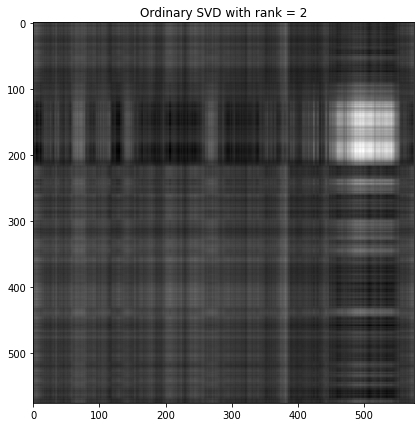

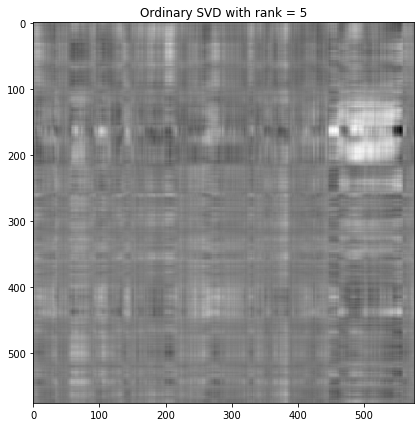

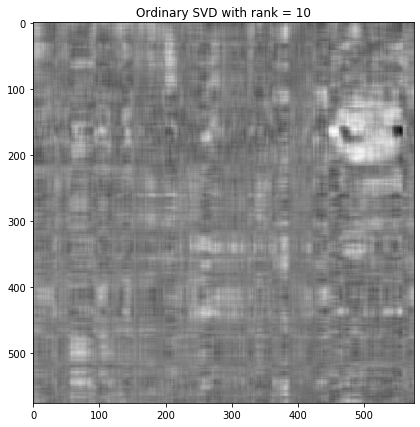

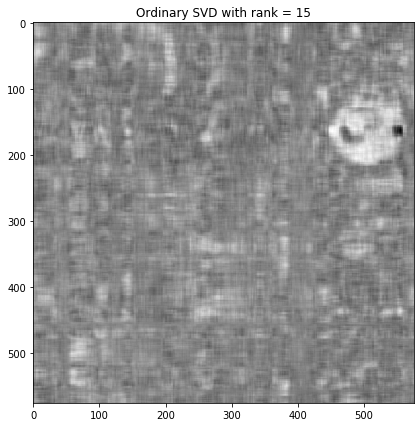

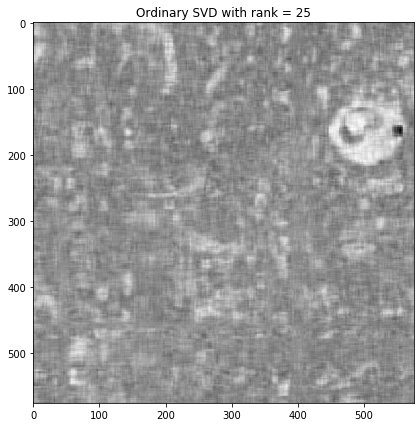

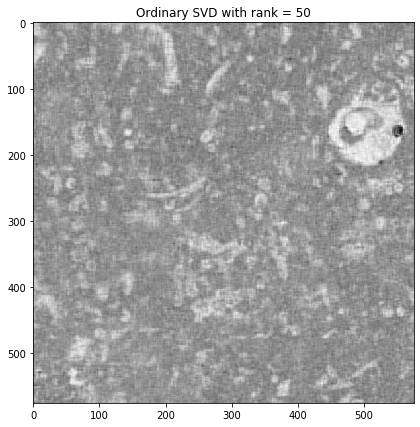

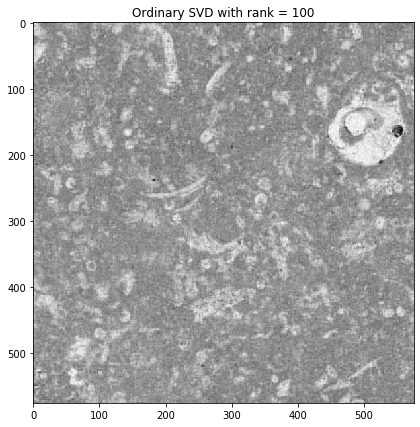

In [0]:
for r in ranks:
    img_svd = get_A_approximation(U_svd, sigma_svd, V_svd, r)
    
    plt.figure(figsize=(7, 7))
    plt.imshow(img_svd, cmap='gray');
    title = "Ordinary SVD with rank = {}".format(r)
    plt.title(title)
    plt.show()

# Shuffled SVD (ssvd) with block size 16

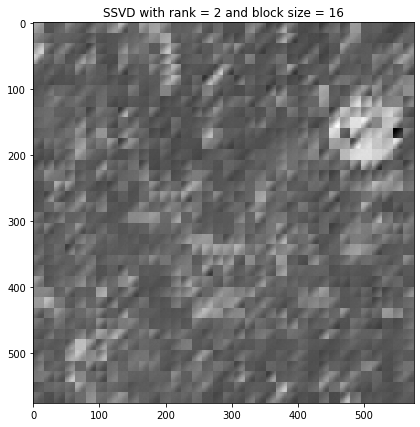

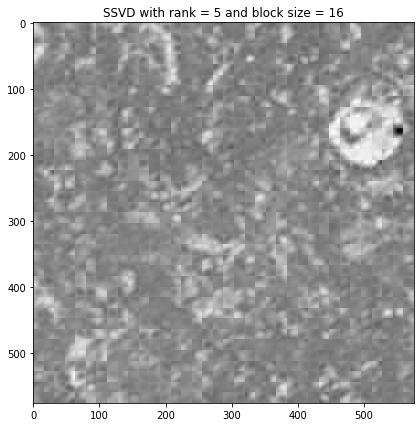

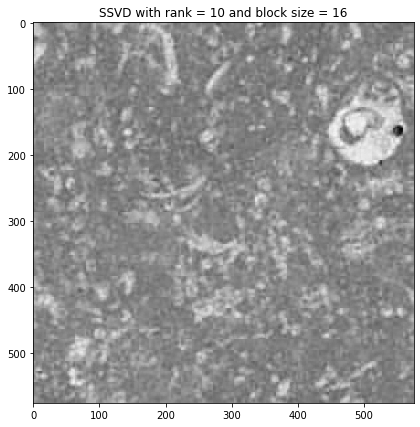

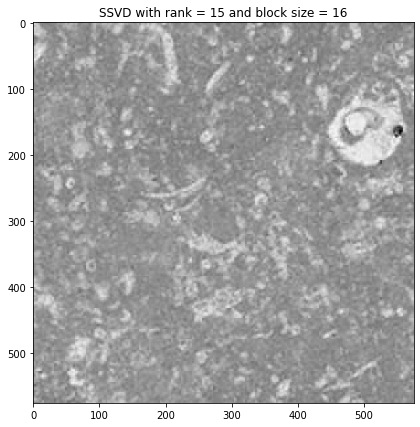

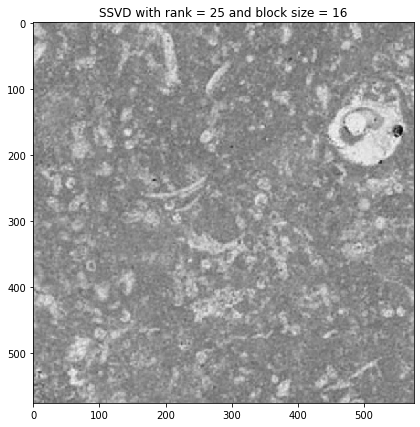

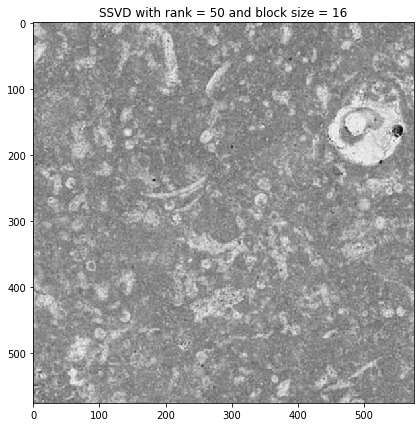

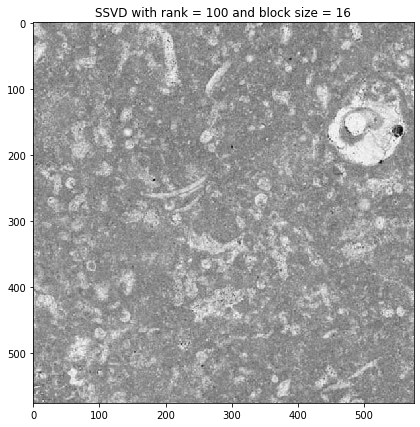

In [0]:
for r in ranks:
    # SSVD 16
    img_16 = get_A_approximation(U_16, sigma_16, V_16, r)
    img_16 = svd_unshuffle(img_16, imgmat.shape, 16)
    plt.figure(figsize=(7, 7))
    plt.imshow(img_16, cmap='gray');
    title = "SSVD with rank = {} and block size = {}".format(r, 16)
    plt.title(title)
    plt.show()

# Shuffled SVD (ssvd) with block size 8

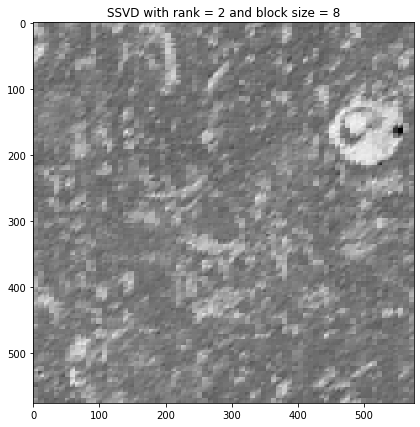

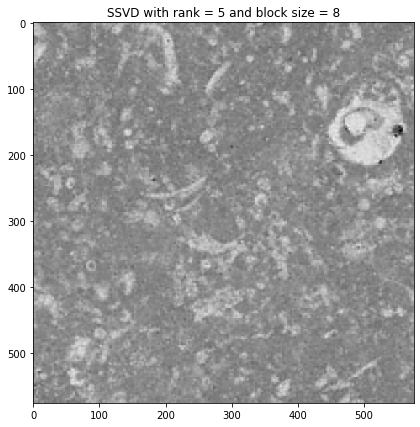

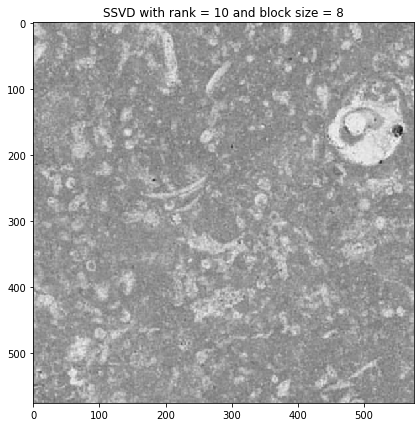

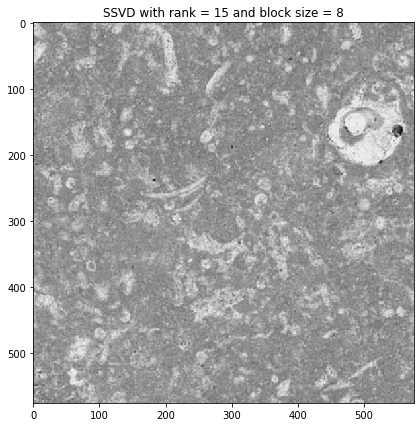

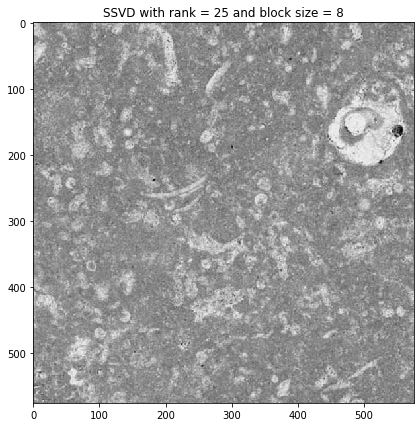

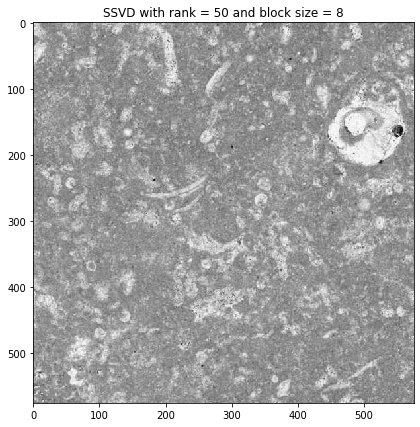

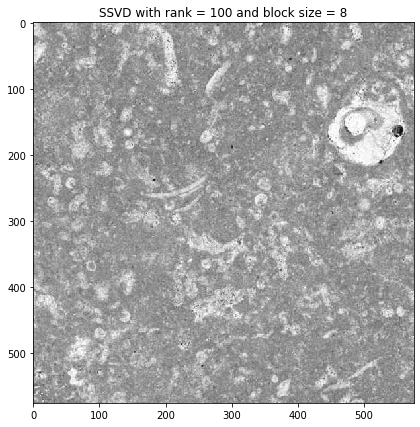

In [0]:
for r in ranks:
    img_8 = get_A_approximation(U_8, sigma_8, V_8, r)
    img_8 = svd_unshuffle(img_8, imgmat.shape, 8)
    plt.figure(figsize=(7, 7))
    plt.imshow(img_8, cmap='gray');
    title = "SSVD with rank = {} and block size = {}".format(r, 8)
    plt.title(title)
    plt.show()

In [0]:
colored_img = np.asarray(img)[1000:1576, 1000:1576, :]
colored_img.shape

(576, 576, 3)

# Compress the rgb image with rank=30 and size of blocks=16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


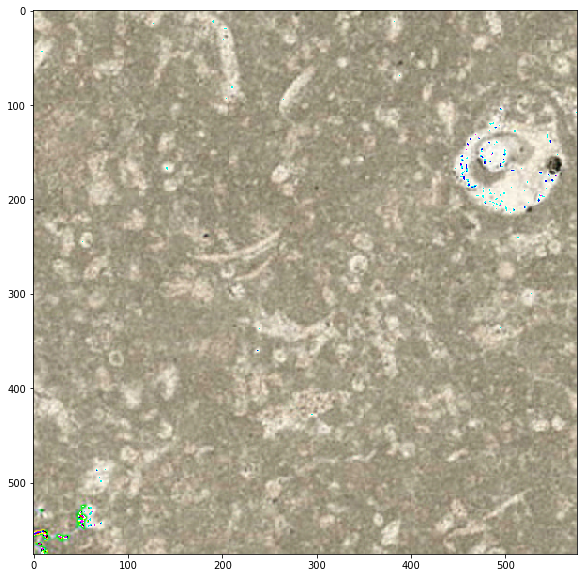

In [0]:
compressedImage = compress_image(
colored_img, 
mode='rgb', 
block_size = 16, 
rank=30
)

# Display the compressed image
plt.figure(figsize=(10,10))
plt.imshow(compressedImage);

# Compress the rgb image with rank=30 and size of blocks=8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


(576, 576, 3)


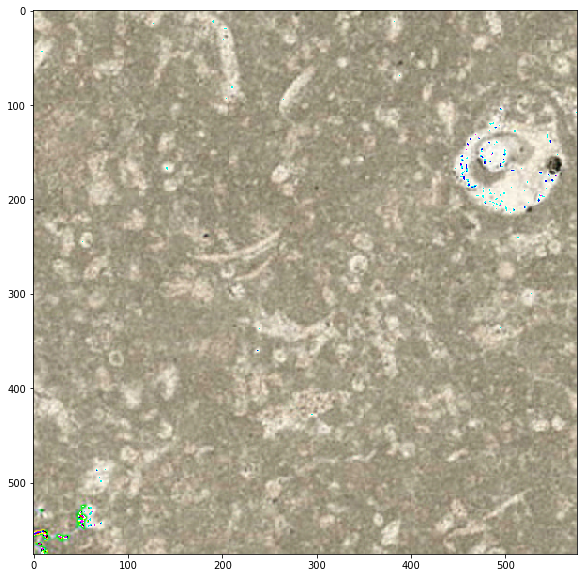

In [0]:
compressedImage = compress_image(
colored_img, 
mode='rgb', 
block_size = 8, 
rank=30
)
print(compressedImage.shape)
# Display the compressed image
plt.figure(figsize=(10,10))
plt.imshow(compressedImage);

# Part 2. Discrete cosine transform (DCT)

# **DCT Encoder:**

**8x8 Block size Part:**

In [0]:
# Divide the image into 8x8 picxels
# The input is the grayscale squared image, the output is an array of blocks each of them is of size 8x8

def Divide_8(img):
    A =  np.asarray(img)
    block = []   

    r = A.shape[0]
    c = A.shape[1]

    for i in range(0,r-7,8):
        for j in range(0,c-7,8):
            block.append(A[i:i+8,j:j+8]); 
  
    block = np.asarray(block)
         
    return block

In [0]:
# Apply the DCT on each 8x8 block
# the input is the block or size 8x8 , the outer loop limits ( limits of row and columns)
# the output is the block after performimg dct 

def ComputeDCT_8(b,u,v):

    Cos_part = [[math.cos((2*i+1)*j * math.pi/16) for j in range(8)] for i in range(8)]
    Range = [(i,j) for i in range(8) for j in range(8)]

    new_block= 0
    for i,j in Range:
        new_block += b[i][j] * Cos_part[i][u] * Cos_part[j][v]
    if u == 0 and v == 0: new_block = new_block/ 64
    if u == 0 and v!=0: new_block = new_block/ 32
    if u != 0 and v == 0: new_block = new_block / 32
    if u != 0 and v != 0: new_block = new_block / 16
    return new_block    

In [0]:
# Apply the quantization table on 8x8 block (Table 1):
#The input is the block of 8x8 
# The output is the block resulted from dividing the input block by the quantization table
def Quantize8_Table1(block):
   
    table_1 = [[1,1,1,1,1,2,2,4],
            [1,1,1,1,1,2,2,4],
            [1,1,1,1,2,2,2,4],
            [1,1,1,1,2,2,4,8],
            [1,1,2,2,2,2,4,8],
            [2,2,2,2,2,4,8,8],
            [2,2,2,4,4,8,8,16],
            [4,4,4,4,8,8,16,16]]

    table_1 = np.asarray(table_1)
    block =np.asarray(block)
    Q_block = block // table_1
    return (Q_block)

In [0]:
# Apply the quantization table on 8x8 block (Table 2):
#The input is the block of 8x8 
# The output is the block resulted from dividing the input block by the quantization table
def Quantize8_table2(block):
  
    table_2 = [[1,2,4,8,16,32,64,128],
            [2,4,4,8,16,32,64,128],
            [4,4,8,16,32,64,128,128],
            [8,8,16,32,64,128,128,256],
            [16,16,32,64,128,128,256,256],
            [32,32,64,128,128,256,256,256],
            [64,64,128,128,256,256,256,256],
            [128,128,128,256,256,256,256,256]]

    table_2 = np.asarray(table_2)
    block =np.asarray(block)
    Q_block = block // table_2
    return (Q_block)

In [0]:
# convert the 2D block to 1D by zigzag method
# from geeks for geeks : https://www.geeksforgeeks.org/print-matrix-zag-zag-fashion/

def ZigZag(matrix):
  
    matrix = np.asarray(matrix)
    rows = matrix.shape[0]
    columns = matrix.shape[1]
    
    solution=[[] for i in range(rows+columns-1)] 
  
    for i in range(rows): 
        for j in range(columns): 
            sum=i+j 
            if(sum%2 ==0): 
  
            #add at beginning 
                solution[sum].insert(0,matrix[i][j]) 
            else: 
  
            #add at end of the list 
                solution[sum].append(matrix[i][j]) 
          
    u_solution = []
    for i in solution: 
        for j in i: 
            u_solution.append(j)
  
          
    return u_solution          

In [0]:
# Main function for 8x8 block:
# The input is the square image
# The output is 2 vectors of the size of the number of pixcels in the image (one vector represents the the first quantization table division and the other represented 
# the other quantization table division)
#Summary of the algorithm:
# 1.compute the DCT of each block
# 2.compute the quantized block 
# 3.convert the block into a vector by zigzag method
# 4.loop over all the blocks to do the previous processes
# 5.store the small vectors of each block into a big vector

def DCT_encoder_8(I):   # I =  square image
  
    vector_out_1 = []
    vector_out_2 = []

    blocks_8 = Divide_8(I)
  
    for b in blocks_8:
        dct_block = [[ComputeDCT_8(b,u,v) for v in range(8)] for u in range(8)]
        dct_block = np.asarray(dct_block)
        block_quantized_1 = Quantize8_Table1(dct_block)
        block_quantized_2 = Quantize8_table2(dct_block)
        final_vector_1 = ZigZag(block_quantized_1)
        final_vector_2 = ZigZag(block_quantized_2)
        vector_out_1.append(final_vector_1)
        vector_out_2.append(final_vector_2)
    
    return vector_out_1,vector_out_2 

**Main code for 8x8 blocks:**

In [0]:
#Call the main function of the encoder then convert the divided vector into a one vector ( stream of integers)

vector1,vector2 = DCT_encoder_8(imgmat)
vector1 = np.asarray(vector1)
vector2=np.asarray(vector2)
vector1_8 = vector1.flatten()
vector2_8 = vector2.flatten()
print(vector1_8)
print(vector2_8)

print(vector1_8.shape)
print(vector2_8.shape)

[209.   5.   2. ...  -1.   0.  -1.]
[209.   2.   1. ...  -1.   0.  -1.]
(331776,)
(331776,)


**16 X 16 Block size Part:**

In [0]:
# Divide the image into 16x16 picxels
# the input is the squared grayscale image
# the out put is an array of blocks each of size 8x8

def Divide_16(img):
    A =  np.asarray(img)
    block = []   

    r = A.shape[0]
    c = A.shape[1]
    for i in range(0,r-15,16):
        for j in range(0,c-15,16):
            block.append(A[i:i+16,j:j+16]); 
  
    block = np.asarray(block)       
    return block

In [0]:
# Apply the DCT on each 16x16 block
# the input is the block or size 8x8 , the outer loop limits ( limits of row and columns)
# the output is the block after performimg dct 


def ComputeDCT_16(b,u,v):
    Cos_part = [[math.cos((2*i+1)*j * math.pi/32) for j in range(16)] for i in range(16)]
    Range = [(i,j) for i in range(16) for j in range(16)]

    new_block= 0
    for i,j in Range:
        new_block += b[i][j] * Cos_part[i][u] * Cos_part[j][v]
    if u == 0 and v == 0: new_block = new_block/ 64
    if u == 0 and v!=0: new_block = new_block/ 32
    if u != 0 and v == 0: new_block = new_block / 32
    if u != 0 and v != 0: new_block = new_block / 16
    return new_block  

In [0]:
# Apply the quantization table on 16x16 block (Table 1):
#The input is the block of 16x16
# The output is the block resulted from dividing the input block by the quantization table
def Quantize16_Table1(block):
  
    b = [[1,1,1,1,1,2,2,4],
      [1,1,1,1,1,2,2,4],
      [1,1,1,1,2,2,2,4],
      [1,1,1,1,2,2,4,8],
      [1,1,2,2,2,2,4,8],
      [2,2,2,2,2,4,8,8],
      [2,2,2,4,4,8,8,16],
      [4,4,4,4,8,8,16,16]]
      
    o = np.repeat(b,2,axis=1)
    table_1 = np.repeat(o,2,axis=0)
    table_1 = np.asarray(table_1)
    block =np.asarray(block)

    Q_block = block // table_1
    return Q_block

In [0]:
# Apply the quantization table on 16x16 block (Table 2):
#The input is the block of 16x16
# The output is the block resulted from dividing the input block by the quantization table
def Quantize16_table2(block):
    b = [[1,2,4,8,16,32,64,128],
      [2,4,4,8,16,32,64,128],
      [4,4,8,16,32,64,128,128],
      [8,8,16,32,64,128,128,256],
      [16,16,32,64,128,128,256,256],
      [32,32,64,128,128,256,256,256],
      [64,64,128,128,256,256,256,256],
      [128,128,128,256,256,256,256,256]]      


    o = np.repeat(b,2,axis=1)
    table_2 = np.repeat(o,2,axis=0)
    table_2 = np.asarray(table_2)
    block =np.asarray(block)

    Q_block = block // table_2
    return Q_block

In [0]:
# main function for 16x16 block:
# The input is the square image
# The output is 2 vectors of the size of the number of pixcels in the image (one vector represents the the first quantization table division and the other represented 
# the other quantization table division)
#Summary of the algorithm:
# 1.compute the DCT of each block
# 2.compute the quantized block 
# 3.convert the block into a vector by zigzag method
# 4.loop over all the blocks to do the previous processes
# 5.store the small vectors of each block into a big vector

def DCT_encoder_16(I):   # I =  square image
  
    vector_out_1 = []
    vector_out_2 = []

    blocks_16 = Divide_16(I)
    for b in blocks_16:
    
        dct_block = [[ComputeDCT_16(b,u,v) for v in range(16)] for u in range(16)]
        dct_block = np.asarray(dct_block)
        block_quantized_1 = Quantize16_Table1(dct_block)
        block_quantized_2 = Quantize16_table2(dct_block)
        final_vector_1 = ZigZag(block_quantized_1)
        final_vector_2 = ZigZag(block_quantized_2)
        vector_out_1.append(final_vector_1)
        vector_out_2.append(final_vector_2)
    
    return vector_out_1,vector_out_2

**Main code for 16x16 blocks:**

In [0]:
# call the main function of the 16x16 DCT encoder and print the two output vectors
vector1,vector2 = DCT_encoder_16(imgmat)
vector1 = np.asarray(vector1)
vector2 =np.asarray(vector2)
vector1_16 = vector1.flatten()
vector2_16 = vector2.flatten()
print(vector1_16)
print(vector2_16)
print(vector1_16.shape)

[788. 101. -62. ...  -1.  -1.  -1.]
[788. 101. -62. ...  -1.  -1.  -1.]
(331776,)


**RunLength Encoder**

In [0]:
import math
import numpy as np 
count=0
w=[]
ind=0
for i in vector1_16 : ####Change this when need to change the dct type
 # print(count)
    ind+=1

    if (i==0):
        count+=1
     
        if  (count==1) : #To append the zero only once
            w.append(0)
        if (ind==len(vector1_16)):   ####Change this also
      
            w.append(count)
     

      
    else :
        if (count==0):
            w.append(i)
        else :
         
            w.append(count)
            count=0
            w.append(i)
print(w)

[788.0, 101.0, -62.0, -2.0, 78.0, -26.0, 11.0, -11.0, -8.0, 5.0, 3.0, 6.0, 31.0, -9.0, 5.0, 6.0, -19.0, -13.0, 36.0, 9.0, -25.0, -14.0, -25.0, -6.0, 19.0, -2.0, 9.0, 6.0, 12.0, 4.0, -8.0, -25.0, 3.0, 4.0, -3.0, -2.0, -5.0, -13.0, 2.0, 0, 1, -29.0, -10.0, -1.0, -15.0, -8.0, 2.0, 3.0, -3.0, -20.0, 6.0, 5.0, -11.0, 4.0, 10.0, 1.0, -4.0, -7.0, -8.0, -8.0, -11.0, 3.0, 3.0, 4.0, 6.0, -3.0, 6.0, -1.0, -1.0, 1.0, -4.0, -17.0, -7.0, -5.0, -11.0, -14.0, -6.0, -3.0, 1.0, -2.0, 5.0, 2.0, 17.0, 2.0, -5.0, 14.0, 26.0, -3.0, 15.0, -5.0, 0, 1, -1.0, 0, 1, -1.0, -2.0, 1.0, 3.0, -3.0, -18.0, 10.0, 3.0, 1.0, 4.0, -1.0, -3.0, 0, 1, -1.0, -1.0, -1.0, 1.0, 1.0, -2.0, -5.0, 3.0, 1.0, -4.0, -4.0, -2.0, -2.0, -1.0, -1.0, -1.0, 0, 1, -1.0, -2.0, 0, 1, 2.0, -1.0, 1.0, 0, 1, 2.0, -1.0, -1.0, 0, 1, -1.0, -1.0, 0, 2, -1.0, -1.0, 0, 1, -1.0, -1.0, -1.0, -4.0, 4.0, -1.0, 0, 9, -1.0, -1.0, -3.0, 2.0, 0, 1, -1.0, -1.0, 0, 3, -1.0, 0, 1, 1.0, 0, 3, -1.0, -1.0, -1.0, -1.0, -2.0, 0, 2, -1.0, -1.0, 0, 1, -1.0, 0, 2, -1.0, 

In [0]:
'''import scipy.io
from collections import Counter
a=np.asarray(vector2_8)
#To have the unique elements in an array and their repeatition in a parallel array
b=Counter(vector2_8)
G=list(b.values()) 
o=list(b.keys())
print(b)
print(G)   
print(len(o))
scipy.io.savemat('Repeations.mat', dict(x=G))
scipy.io.savemat('Values.mat', dict(x=o))
scipy.io.savemat('BitsStreem.mat',dict(x=a))'''

"import scipy.io\nfrom collections import Counter\na=np.asarray(vector2_8)\n#To have the unique elements in an array and their repeatition in a parallel array\nb=Counter(vector2_8)\nG=list(b.values()) \no=list(b.keys())\nprint(b)\nprint(G)   \nprint(len(o))\nscipy.io.savemat('Repeations.mat', dict(x=G))\nscipy.io.savemat('Values.mat', dict(x=o))\nscipy.io.savemat('BitsStreem.mat',dict(x=a))"

**ٌRunLength Encoder** 

In [0]:
k=[]
c=0
n=1
W=w.copy() #Just to keep W untouched 
for i in W:
    c+=1
    if (i!=0):
        k.append(i)
    else:
     
        R=W[c]
        for j in range(R):
            k.append(0)
        del W[c]
D=np.transpose(k)
D

array([788., 101., -62., ...,  -1.,  -1.,  -1.])

In [0]:
##



#                                           **DCT Decoder:**





**IDCT for 8x8 blocks Part:**

In [0]:
# Inverse zigzag function
# the input is the vector of the same size of image pixcels
# from: https://github.com/getsanjeev/compression-DCT/blob/master/zigzag.py
def inverse_zigzag(input, vmax, hmax):


    h = 0
    v = 0

    vmin = 0
    hmin = 0

    output = np.zeros((vmax, hmax))

    i = 0


    while ((v < vmax) and (h < hmax)): 
        #print ('v:',v,', h:',h,', i:',i)   
        if ((h + v) % 2) == 0:                 # going up

            if (v == vmin):
                #print(1)

                output[v, h] = input[i]        # if we got to the first line

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                #print(2)
                output[v, h] = input[i] 
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                #print(3)
                output[v, h] = input[i] 
                v = v - 1
                h = h + 1
                i = i + 1


        else:                                    # going down

            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                #print(4)
                output[v, h] = input[i] 
                h = h + 1
                i = i + 1

            elif (h == hmin):                  # if we got to the first column
                #print(5)
                output[v, h] = input[i] 
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1

            elif((v < vmax -1) and (h > hmin)):     # all other cases
                output[v, h] = input[i] 
                v = v + 1
                h = h - 1
                i = i + 1




        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            #print(7)        
            output[v, h] = input[i] 
            break


    return output


In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 8x8
#the output is a block results from multiply the input block by the quantization table
def inverse_Quantize8_Table1(block):
    table_1 = [[1,1,1,1,1,2,2,4],
            [1,1,1,1,1,2,2,4],
            [1,1,1,1,2,2,2,4],
            [1,1,1,1,2,2,4,8],
            [1,1,2,2,2,2,4,8],
            [2,2,2,2,2,4,8,8],
            [2,2,2,4,4,8,8,16],
            [4,4,4,4,8,8,16,16]]

    table_1 = np.asarray(table_1)
    block =np.asarray(block)

    Q_block = np.multiply(block,table_1)
    return Q_block

In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 8x8
#the output is a block results from multiply the input block by the quantization table
def inverse_Quantize8_table2(block):
    table_2 = [[1,2,4,8,16,32,64,128],
            [2,4,4,8,16,32,64,128],
            [4,4,8,16,32,64,128,128],
            [8,8,16,32,64,128,128,256],
            [16,16,32,64,128,128,256,256],
            [32,32,64,128,128,256,256,256],
            [64,64,128,128,256,256,256,256],
            [128,128,128,256,256,256,256,256]]

    table_2 = np.asarray(table_2)
    block =np.asarray(block)

    Q_block = np.multiply(block,table_2)
    return Q_block


In [0]:
# compute the inverse DCT by multiply the block by the corresponding cofficient in the DCT matrix
# the input is the block and the limits of the outer summations ( no.row and no.columns)
# the output is the block after IDCT 
def ComputeIDCT_8(a,i,j):
    Cos_part = [[math.cos((2*i+1)*j * math.pi/16) for j in range(8)] for i in range(8)]
    Range = [(i,j) for i in range(8) for j in range(8)]

    inverse_block = 0

    for u,v in Range:
        block = a[u][v] * Cos_part[i][u] * Cos_part[j][v]
        inverse_block += block
    
    return (np.floor(inverse_block))

In [0]:
# Main function of the decoder 8x8 block size:
# the input is the vector with same size of the original image number of pixcels
# the output is the compressed image
# Summary of Algorithm:
# 1.apply the inverse zigzag to convert the vector into block
# 2.inverse the quantization process
# 3.compute the IDCT of the block
# 4.loop over all the vector to do the previous processes
# 5.store the final blocks in an array
# 6.reconstruct the image from the final array of blocks
def IDCT_driver_8(vector):
    
    coded_input1_8 = vector
    coded_input1_8 = coded_input1_8.reshape(5184,64)
    i_final_blocks = []
    for c in coded_input1_8:
        i_blocks8_1 = inverse_zigzag(c, 8, 8)
        i_Qblocks8_1 = inverse_Quantize8_Table1(i_blocks8_1)
        i_dct_blocks8_1 = [[ComputeIDCT_8(i_Qblocks8_1,i,j) for j in range(8)] for i in range(8)] 
        i_final_blocks.append(i_dct_blocks8_1)

    i_final_blocks = np.asarray(i_final_blocks)

    # reconstruct the image:
    a = i_final_blocks

    image = np.zeros((576,576))

    k = 0
    for i in range(0,576,8):
        for j in range(0,576,8):
    
    
            image[i:i+8,j:j+8] = a[k]

            k = k+1

    return(image)

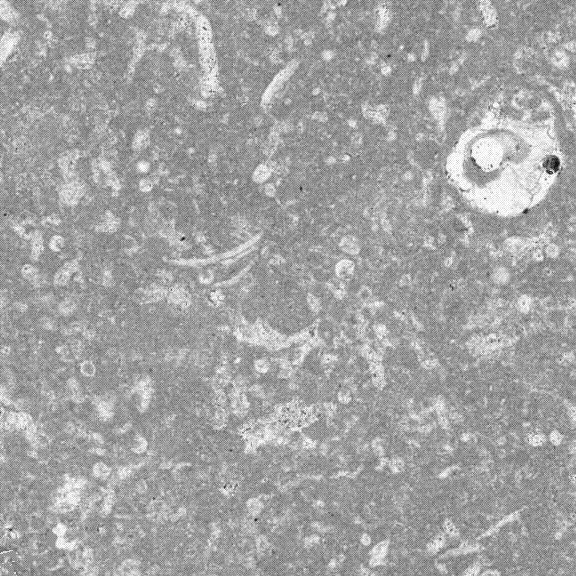

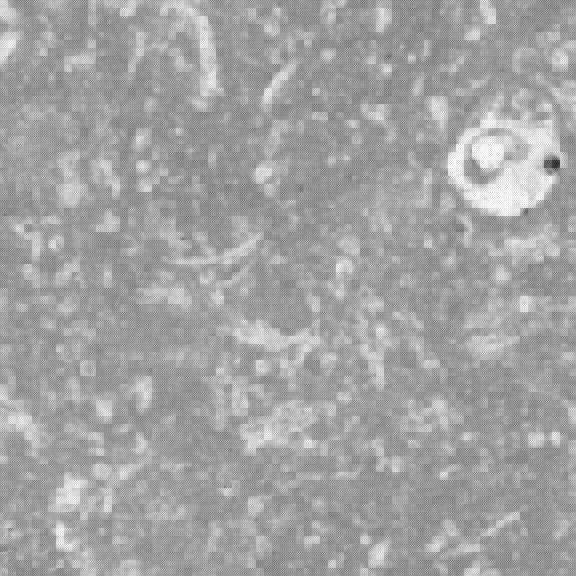

In [0]:
# main code for IDDCT 8x8:
# call the main function for IDCT 8x8 and show the images
import cv2
from google.colab.patches import cv2_imshow
re_image_1 = IDCT_driver_8(vector1_8)
re_image_2 = IDCT_driver_8(vector2_8)

cv2_imshow(re_image_1)
cv2_imshow(re_image_2)

**IDCT for 16x16 block Part:**

In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 16x16
#the output is a block results from multiply the input block by the quantization table
# the quantization table here is the same as 8x8 but we extend it to be 16x16 by repeats each row and column one time
def inverse_Quantize16_Table1(block):
    b = [[1,1,1,1,1,2,2,4],
         [1,1,1,1,1,2,2,4],
         [1,1,1,1,2,2,2,4],
         [1,1,1,1,2,2,4,8],
         [1,1,2,2,2,2,4,8],
         [2,2,2,2,2,4,8,8],
         [2,2,2,4,4,8,8,16],
         [4,4,4,4,8,8,16,16]]


    o = np.repeat(b,2,axis=1)
    table_1 = np.repeat(o,2,axis=0)
    table_1 = np.asarray(table_1)
    block =np.asarray(block)
    Q_block = np.multiply(block,table_1)
    return Q_block

In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 16x16
#the output is a block results from multiply the input block by the quantization table
# the quantization table here is the same as 8x8 but we extend it to be 16x16 by repeats each row and column one time
def inverse_Quantize16_table2(block):
    b = [[1,2,4,8,16,32,64,128],
      [2,4,4,8,16,32,64,128],
      [4,4,8,16,32,64,128,128],
      [8,8,16,32,64,128,128,256],
      [16,16,32,64,128,128,256,256],
      [32,32,64,128,128,256,256,256],
      [64,64,128,128,256,256,256,256],
      [128,128,128,256,256,256,256,256]]


    o = np.repeat(b,2,axis=1)
    table_2 = np.repeat(o,2,axis=0)
    table_2 = np.asarray(table_2)
    block =np.asarray(block)
    Q_block = np.multiply(block, table_2)
    return Q_block

In [0]:
# compute the inverse DCT by multiply the block by the corresponding cofficient in the DCT matrix
# the input is the block and the limits of the outer summations ( no.row and no.columns)
# the output is the block after IDCT 
def ComputeIDCT_16(a,i,j):
    Cos_part = [[math.cos((2*i+1)*j * math.pi/32) for j in range(16)] for i in range(16)]
    Range = [(i,j) for i in range(16) for j in range(16)]

    inverse_block = 0

    for u,v in Range:
        block = a[u][v] * Cos_part[i][u] * Cos_part[j][v]
        inverse_block += block


    inverse_block = inverse_block * 0.25
    return (np.floor(inverse_block))

In [0]:
# main function for IDCT 16x16
# Main function of the decoder 8x8 block size:
# the input is the vector with same size of the original image number of pixcels
# the output is the compressed image
# Summary of Algorithm:
# 1.apply the inverse zigzag to convert the vector into block
# 2.inverse the quantization process
# 3.compute the IDCT of the block
# 4.loop over all the vector to do the previous processes
# 5.store the final blocks in an array
# 6.reconstruct the image from the final array of blocks
def IDCT_driver_16(vector):


    coded_input1_16 = vector
    coded_input1_16 = coded_input1_16.reshape(1296,256)
    i_final_blocks = []
    for c in coded_input1_16:
        i_blocks16_1 = inverse_zigzag(c, 16, 16)
        i_Qblocks16_1 = inverse_Quantize16_Table1(i_blocks16_1)
        i_dct_blocks16_1 = [[ComputeIDCT_16(i_Qblocks16_1,i,j) for j in range(16)] for i in range(16)] 
        i_final_blocks.append(i_dct_blocks16_1)

    i_final_blocks = np.asarray(i_final_blocks)
  
  # reconstruct the image:
    a = i_final_blocks

    image = np.zeros((576,576))

    k = 0
    for i in range(0,576,16):
        for j in range(0,576,16):
    
    
            image[i:i+16,j:j+16] = a[k]
    
            k = k+1

  
    return(image)

**Main code for IDCT 16x16 blocks:**

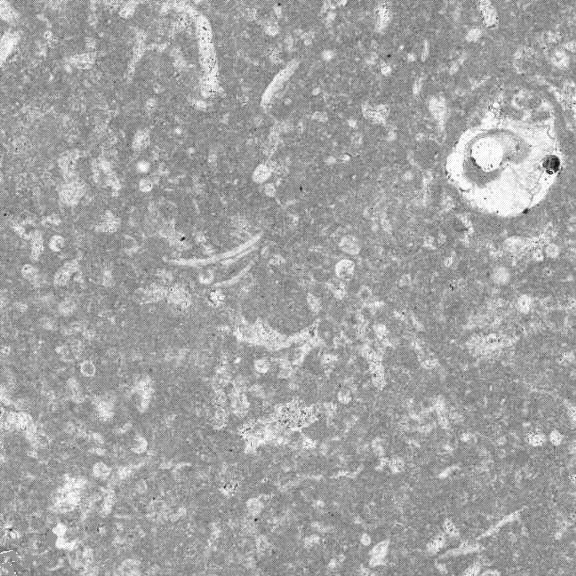

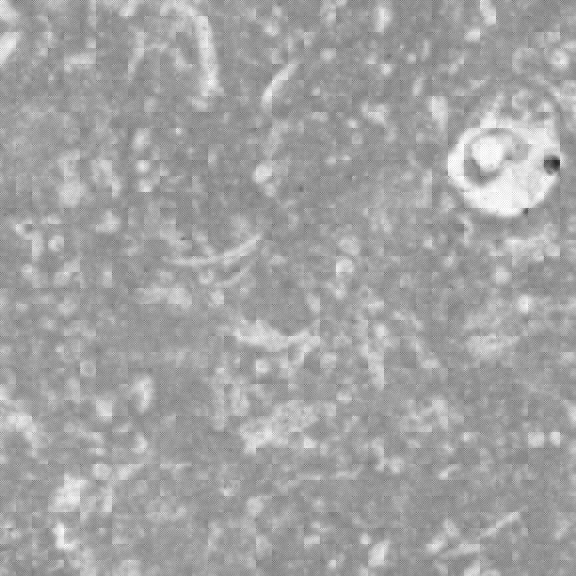

In [0]:
# main code for IDDCT 16x16:
# call the main function for IDCT 16x16 and show the images
import cv2
from google.colab.patches import cv2_imshow
re_image_3 = IDCT_driver_16(vector1_16)
re_image_4 = IDCT_driver_16(vector2_16)
cv2_imshow(re_image_3)
cv2_imshow(re_image_4)

In [0]:
# calculate the MSE:
def Calc_MSE(I_original,I_compressed):
    difference = I_original - I_compressed
    square_diff = difference**2
    square_diff = np.matrix(square_diff)
    summer = square_diff.sum()
    MSE = summer/(I_original.shape[0]*I_original.shape[1])

    return MSE

In [0]:
# Image 8x8 table 1:
MSE_1 = Calc_MSE(imgmat,re_image_1)
print('Image 1',MSE_1)

# Image 8x8 table 2 :
MSE_2 = Calc_MSE(imgmat,re_image_2)
print('Image 2',MSE_2)

# Image 16x16 table 1 :
MSE_3 = Calc_MSE(imgmat,re_image_3)
print('Image 3',MSE_3)

# Image 16x16 table 2:
MSE_4 = Calc_MSE(imgmat,re_image_4)
print('Image 4',MSE_4)


Image 1 2521.2947259596835
Image 2 2576.7001320167824
Image 3 472.3543083285108
Image 4 502.9915665991512
